# Importing the necessary libraries

In [9]:
import platform
import subprocess
import tensorflow as tf
print("Operating System:", platform.system())
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    gpu_name = gpus[0].name.split(':')[-1].strip()
    print(f"TensorFlow is using the following GPU: {gpu_name}")
else:
    print("TensorFlow is not using any GPU.")
output = subprocess.check_output("nvidia-smi", encoding='utf-8')
print("NVIDIA GPU Information:\n" + "-" * 30)
print(output)


Operating System: Linux
TensorFlow is using the following GPU: 0
NVIDIA GPU Information:
------------------------------
Fri Nov  1 18:36:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.31.01              Driver Version: 560.81         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650        On  |   00000000:01:00.0 Off |                  N/A |
| N/A   61C    P0             17W /   50W |    2618MiB /   4096MiB |      7%      Default |
|                   

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
# Use the updated import path for ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # If using a compatible version
# Alternatively, you can use:
# from tensorflow.keras.utils import image_dataset_from_directory  # If you want to use dataset loading for TensorFlow datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
import os

# Your code for data loading and model building goes here


# Loading the Dataset

In [13]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [14]:
import os
import cv2
import numpy as np

# Define labels and image size
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150

def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        
        # Check if the directory exists
        if not os.path.exists(path):
            print(f"Directory {path} does not exist.")
            continue
            
        # Initialize a counter for successfully loaded images
        loaded_images = 0
        
        for img in os.listdir(path):
            try:
                # Only process image files
                if img.endswith(('.png', '.jpg', '.jpeg')):
                    img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                    if img_arr is None:
                        print(f"Failed to load image: {os.path.join(path, img)}")
                        continue
                    
                    resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Reshaping images to preferred size
                    data.append([resized_arr, class_num])
                    loaded_images += 1
            except Exception as e:
                print(f"Error processing image {img}: {e}")
        
        print(f"Finished loading {loaded_images} images from {path}.")
    
    # Convert the list to a numpy array and ensure it's homogeneous
    data = [d for d in data if d[0] is not None]  # Filter out None entries
    return np.array(data, dtype=object)  # Use dtype=object to handle the sequences

# Load data
train = get_training_data('/kaggle/working/chest/chest_xray/chest_xray/train')
test = get_training_data('/kaggle/working/chest/chest_xray/chest_xray/test')
val = get_training_data('/kaggle/working/chest/chest_xray/chest_xray/val')

# Print the shapes of the loaded data
print("Training data shape:", train.shape)
print("Test data shape:", test.shape)
print("Validation data shape:", val.shape)


Finished loading 3875 images from /kaggle/working/chest/chest_xray/chest_xray/train/PNEUMONIA.
Finished loading 1341 images from /kaggle/working/chest/chest_xray/chest_xray/train/NORMAL.
Finished loading 390 images from /kaggle/working/chest/chest_xray/chest_xray/test/PNEUMONIA.
Finished loading 234 images from /kaggle/working/chest/chest_xray/chest_xray/test/NORMAL.
Finished loading 8 images from /kaggle/working/chest/chest_xray/chest_xray/val/PNEUMONIA.
Finished loading 8 images from /kaggle/working/chest/chest_xray/chest_xray/val/NORMAL.
Training data shape: (5216, 2)
Test data shape: (624, 2)
Validation data shape: (16, 2)


# Data Visualization & Preprocessing

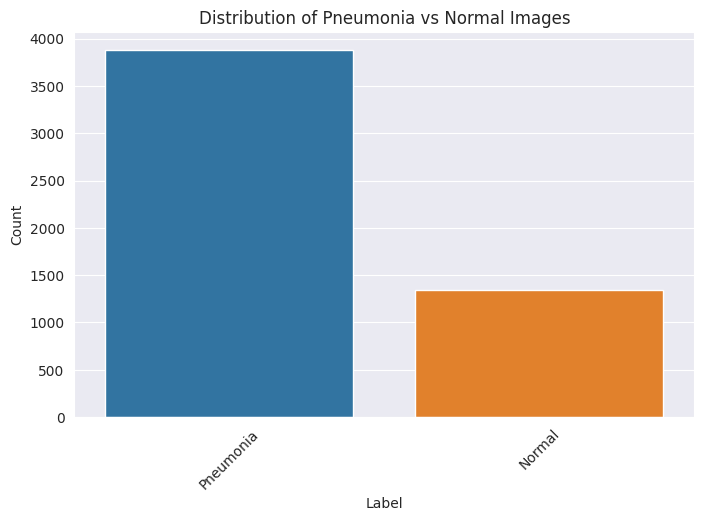

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Initialize an empty list to hold the labels
l = []

# Extract labels from the train dataset
for image, label in train:
    if label == 0:
        l.append("Pneumonia")
    else:
        l.append("Normal")

# Convert the list to a Pandas Series
label_series = pd.Series(l)

# Set the seaborn style
sns.set_style('darkgrid')

# Create a count plot for the labels
plt.figure(figsize=(8, 5))  # Optional: Set the figure size
sns.countplot(x=label_series)  # Use the Pandas Series directly
plt.title("Distribution of Pneumonia vs Normal Images")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Optional: Rotate x-axis labels for better visibility
plt.show()



# Display the first images in the training set

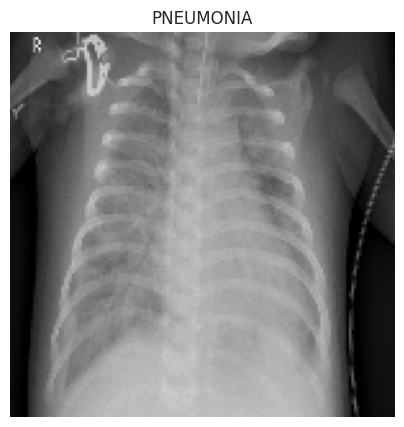

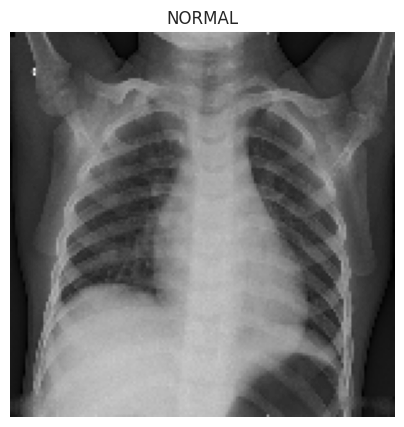

In [16]:
# Display the first image in the training set
plt.figure(figsize=(5, 5))
plt.imshow(train[0][0].reshape(img_size, img_size), cmap='gray')  # Reshape to (150, 150)
plt.title(labels[train[0][1]])
plt.axis('off')  # Optional: Removes axis for a cleaner look

# Display the last image in the training set
plt.figure(figsize=(5, 5))
plt.imshow(train[-1][0].reshape(img_size, img_size), cmap='gray')  # Reshape to (150, 150)
plt.title(labels[train[-1][1]])
plt.axis('off')  # Optional: Removes axis for a cleaner look

plt.show()


In [17]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

**grayscale normalization to reduce the effect of illumination's differences**

In [18]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [19]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Data Augmentation

In [20]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

# Training the Model

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

def create_model():
    # Input layer for grayscale images
    input_tensor = Input(shape=(150, 150, 1))
    
    # Convert grayscale input to RGB by repeating the single channel 3 times
    x = Conv2D(3, (3, 3), padding='same', activation='relu')(input_tensor)  # Convert to 3 channels
    
    # Load the ResNet50V2 model without the top layer
    resnet_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)  # ResNet expects 3-channel input
    )

    # Freeze the ResNet layers
    for layer in resnet_model.layers:
        layer.trainable = False

    # Pass the RGB-converted input through ResNet
    x = resnet_model(x)
    
    # Global average pooling and dense layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    
    # Output layer
    predictions = Dense(1, activation='sigmoid')(x)  # Binary classification

    # Create the final model
    res_model = tf.keras.Model(inputs=input_tensor, outputs=predictions)

    # Compile the model
    res_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    return res_model

# Create and summarize the model
res_model = create_model()
res_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 150, 150, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 5, 5, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,827,231 (90.89 MB)

 Trainable params: 262,431 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Initialize the model
model = Sequential()

# Convolutional Block 1
model.add(Conv2D(32, (3, 3), strides=1, padding='same', input_shape=(150, 150, 1)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(Dropout(0.2))

# Convolutional Block 2
model.add(Conv2D(64, (3, 3), strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(Dropout(0.3))

# Convolutional Block 3
model.add(Conv2D(128, (3, 3), strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(Dropout(0.3))

# Convolutional Block 4
model.add(Conv2D(256, (3, 3), strides=1, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=2, padding='same'))
model.add(Dropout(0.4))

# Fully Connected Layer
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 38, 38, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 38, 38, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 19, 19, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 19, 19, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,553,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             

 Total params: 7,727,713 (29.48 MB)

 Trainable params: 7,726,753 (29.48 MB)

 Non-trainable params: 960 (3.75 KB)

In [41]:
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',min_lr=0.000001,
                                          patience=8,verbose=1,factor=0.5,)

In [42]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=12)

In [25]:
import tensorflow as tf
import os

# Set GPU allocator and enable memory growth
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Clear session to free up any residual memory
tf.keras.backend.clear_session()

# Reduce batch size to manage memory usage
history = res_model.fit(
    datagen.flow(x_train, y_train, batch_size=32),  
    epochs=32,
    validation_data=datagen.flow(x_val, y_val, batch_size=32),
    # steps_per_epoch=100,
    callbacks=[early_stopping,lr],
    verbose=1
)


Physical devices cannot be modified after being initialized
Epoch 1/32


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730479507.823285     378 service.cc:145] XLA service 0x7f3aec004220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730479507.823724     378 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-11-01 16:45:08.119407: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-01 16:45:09.411257: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-11-01 16:45:16.087226

  1/163 ━━━━━━━━━━━━━━━━━━━━ 1:01:12 23s/step - accuracy: 0.5938 - loss: 0.7161

I0000 00:00:1730479524.029233     378 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 166ms/step - accuracy: 0.8707 - loss: 0.3043 - val_accuracy: 0.6875 - val_loss: 1.0903 - learning_rate: 0.0010
Epoch 2/32
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.9105 - loss: 0.2142 - val_accuracy: 0.6250 - val_loss: 1.1868 - learning_rate: 0.0010
Epoch 3/32
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 159ms/step - accuracy: 0.9242 - loss: 0.1847 - val_accuracy: 0.6875 - val_loss: 1.1003 - learning_rate: 0.0010
Epoch 4/32
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - accuracy: 0.9371 - loss: 0.1568 - val_accuracy: 0.5625 - val_loss: 1.5344 - learning_rate: 0.0010
Epoch 5/32
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - accuracy: 0.9358 - loss: 0.1657 - val_accuracy: 0.6250 - val_loss: 1.6065 - learning_rate: 0.0010
Epoch 6/32
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - accuracy: 0.9366 - loss: 0.1557 - val_accuracy: 0.6875 - val_loss: 0.8201 - learning_rate: 0.0010
Epoch 7/32
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 126ms/step - accuracy: 0.9434 - loss:

In [56]:
print("Loss of the model is - " , res_model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , res_model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9387 - loss: 0.1631
Loss of the model is -  0.22126957774162292
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9387 - loss: 0.1631
Accuracy of the model is -  91.82692170143127 %


In [43]:

history2 = model.fit(
    datagen.flow(x_train, y_train, batch_size=32, shuffle=True),  # Ensure data is shuffled
    epochs=32,  # Increased epochs for better training
    validation_data=datagen.flow(x_val, y_val, batch_size=32),
  # Specify validation steps
    callbacks=[lr,early_stopping],
    verbose=1  
)


Epoch 1/32


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 39s 116ms/step - accuracy: 0.6650 - loss: 3.5365 - val_accuracy: 0.5000 - val_loss: 1.1889 - learning_rate: 0.0010
Epoch 2/32
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 108ms/step - accuracy: 0.7430 - loss: 0.5338 - val_accuracy: 0.5000 - val_loss: 1.2236 - learning_rate: 0.0010
Epoch 3/32
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - accuracy: 0.7545 - loss: 0.3611 - val_accuracy: 0.5000 - val_loss: 3.9277 - learning_rate: 0.0010
Epoch 4/32
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 110ms/step - accuracy: 0.8007 - loss: 0.3419 - val_accuracy: 0.5000 - val_loss: 3.4412 - learning_rate: 0.0010
Epoch 5/32
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.8555 - loss: 0.3079 - val_accuracy: 0.5000 - val_loss: 2.8636 - learning_rate: 0.0010
Epoch 6/32
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.8753 - loss: 0.2897 - val_accuracy: 0.5625 - val_loss: 2.6258 - learning_rate: 0.0010
Epoch 7/32
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.8900 - loss:

In [55]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8202 - loss: 0.2759
Loss of the model is -  0.27814656496047974
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8202 - loss: 0.2759
Accuracy of the model is -  84.29487347602844 %


# Analysis after Model Training

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9387 - loss: 0.1631
Loss of ResNet50V2 model is -  0.22126957774162292
Accuracy of ResNet50V2 model is -  91.82692170143127 %
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8202 - loss: 0.2759
Loss of the other model is -  0.27814656496047974
Accuracy of the other model is -  84.29487347602844 %


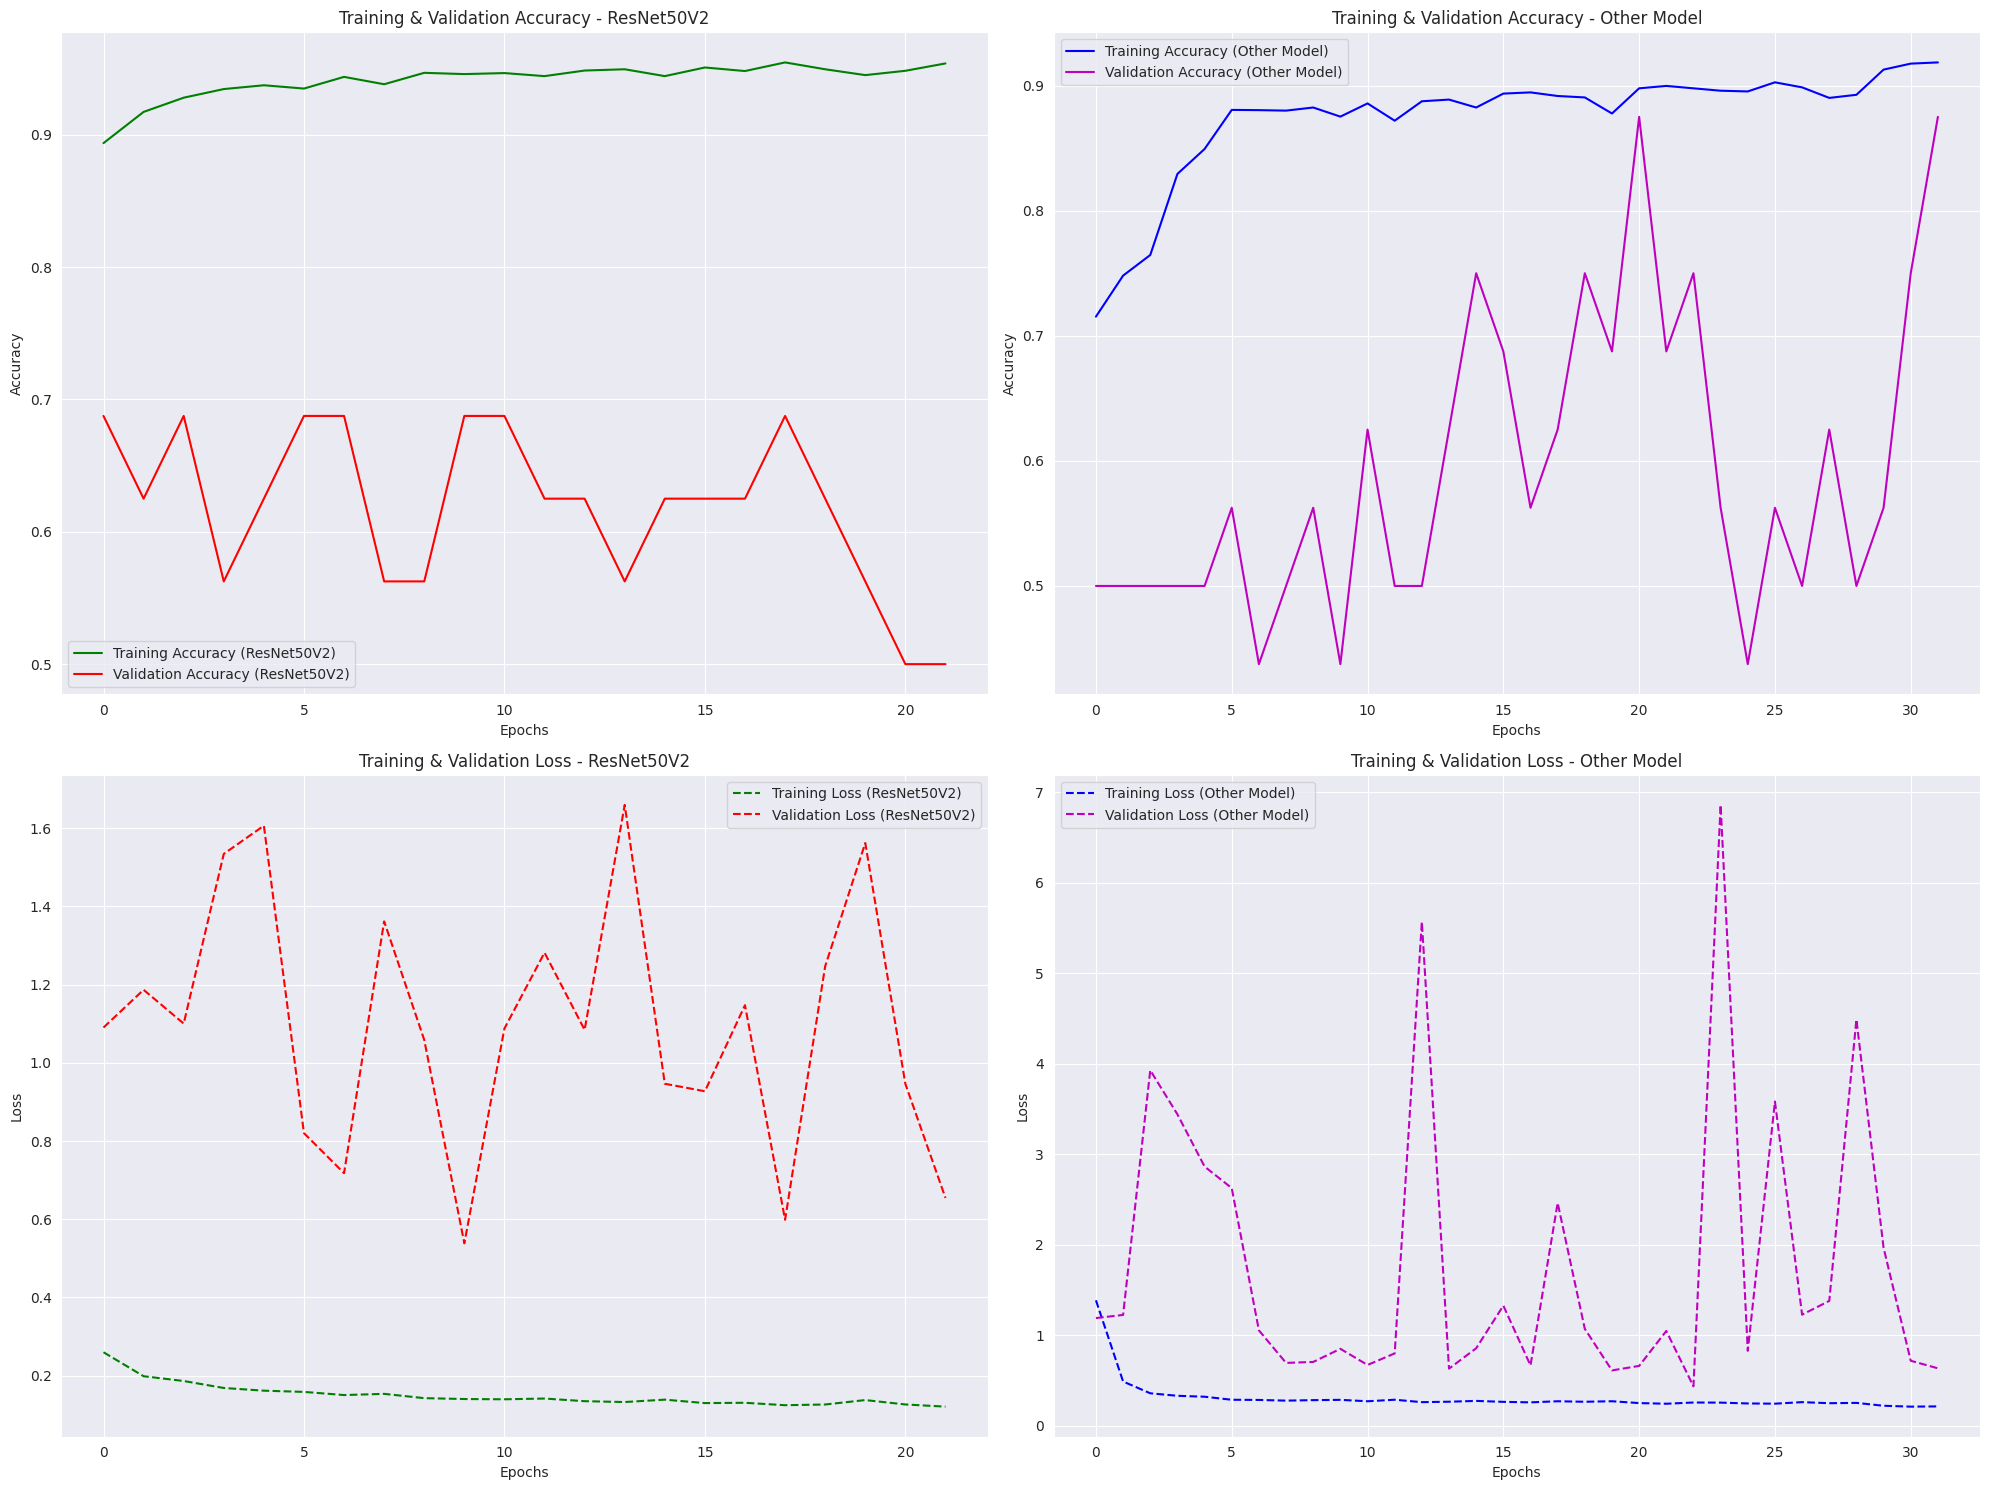

The winner is: ResNet50V2


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import seaborn as sns
import numpy as np


# Evaluate ResNet50V2
loss_resnet, accuracy_resnet = res_model.evaluate(x_test, y_test)
print("Loss of ResNet50V2 model is - ", loss_resnet)
print("Accuracy of ResNet50V2 model is - ", accuracy_resnet * 100, "%")

# Evaluate the other model
loss_other, accuracy_other = model.evaluate(x_test, y_test)
print("Loss of the other model is - ", loss_other)
print("Accuracy of the other model is - ", accuracy_other * 100, "%")

# Define the number of epochs and epoch ranges
num_epochs_resnet = len(history.history['accuracy'])
num_epochs_other = len(history2.history['accuracy'])
epochs_resnet = range(num_epochs_resnet)
epochs_other = range(num_epochs_other)

# Create subplots for training and validation accuracy/loss comparisons
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

# Accuracy plots for ResNet50V2
ax[0, 0].plot(epochs_resnet, history.history['accuracy'], 'g-', label='Training Accuracy (ResNet50V2)')
ax[0, 0].plot(epochs_resnet, history.history['val_accuracy'], 'r-', label='Validation Accuracy (ResNet50V2)')
ax[0, 0].set_title('Training & Validation Accuracy - ResNet50V2')
ax[0, 0].set_xlabel("Epochs")
ax[0, 0].set_ylabel("Accuracy")
ax[0, 0].legend()

# Accuracy plots for the other model
ax[0, 1].plot(epochs_other, history2.history['accuracy'], 'b-', label='Training Accuracy (Other Model)')
ax[0, 1].plot(epochs_other, history2.history['val_accuracy'], 'm-', label='Validation Accuracy (Other Model)')
ax[0, 1].set_title('Training & Validation Accuracy - Other Model')
ax[0, 1].set_xlabel("Epochs")
ax[0, 1].set_ylabel("Accuracy")
ax[0, 1].legend()

# Loss plots for ResNet50V2
ax[1, 0].plot(epochs_resnet, history.history['loss'], 'g--', label='Training Loss (ResNet50V2)')
ax[1, 0].plot(epochs_resnet, history.history['val_loss'], 'r--', label='Validation Loss (ResNet50V2)')
ax[1, 0].set_title('Training & Validation Loss - ResNet50V2')
ax[1, 0].set_xlabel("Epochs")
ax[1, 0].set_ylabel("Loss")
ax[1, 0].legend()

# Loss plots for the other model
ax[1, 1].plot(epochs_other, history2.history['loss'], 'b--', label='Training Loss (Other Model)')
ax[1, 1].plot(epochs_other, history2.history['val_loss'], 'm--', label='Validation Loss (Other Model)')
ax[1, 1].set_title('Training & Validation Loss - Other Model')
ax[1, 1].set_xlabel("Epochs")
ax[1, 1].set_ylabel("Loss")
ax[1, 1].legend()

# Adjust layout for readability
plt.tight_layout()
plt.show()

# Function to plot ROC and Precision-Recall curves
def plot_curves(y_true, y_scores, model_name):
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.show()

winner = "ResNet50V2" if accuracy_resnet > accuracy_other else "Other Model"
print(f"The winner is: {winner}")


In [63]:
predictions = res_model.predict(x_test)

# Flatten the predictions if it has more than one dimension
predictions = predictions.flatten() if predictions.ndim > 1 else predictions

# Apply threshold to convert probabilities to class labels
threshold = 0.5  # Adjust if necessary
predicted_classes = (predictions >= threshold).astype(int)



# Now you can print the classification report
print(classification_report(y_test, predicted_classes, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step
                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.95      0.94       390
   Normal (Class 1)       0.92      0.86      0.89       234

           accuracy                           0.92       624
          macro avg       0.92      0.91      0.91       624
       weighted avg       0.92      0.92      0.92       624



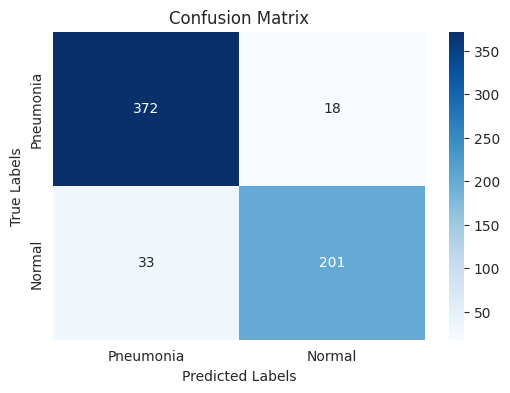

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Pneumonia', 'Normal'], yticklabels=['Pneumonia', 'Normal'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

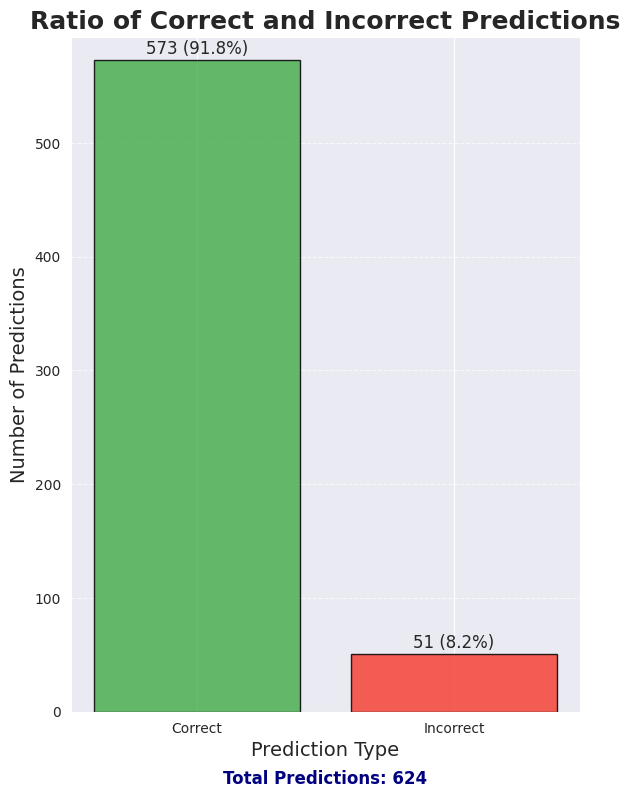

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


correct = np.where(predicted_classes == y_test)[0]  # Indices where prediction matches the true label
incorrect = np.where(predicted_classes != y_test)[0]  # Indices where prediction does not match the true label
num_correct = len(correct)  # Number of correct predictions
num_incorrect = len(incorrect)  # Number of incorrect predictions

# Data for plotting
labels = ['Correct', 'Incorrect']
values = [num_correct, num_incorrect]
total_predictions = num_correct + num_incorrect
percentages = [num_correct / total_predictions * 100, num_incorrect / total_predictions * 100]

# Create a bar plot
plt.figure(figsize=(6,8))
bars = plt.bar(labels, values, color=['#4CAF50', '#F44336'], edgecolor='black', alpha=0.85)

# Add percentage labels above the bars with an advanced layout
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 2,  # Adjusted for better visibility
             f'{values[i]} ({percentages[i]:.1f}%)', 
             ha='center', va='bottom', fontsize=12,)

# Set titles and labels with improved font sizes
plt.title('Ratio of Correct and Incorrect Predictions', fontsize=18, fontweight='bold')
plt.xlabel('Prediction Type', fontsize=14)
plt.ylabel('Number of Predictions', fontsize=14)
plt.ylim(0, max(values) + 20)  # Adjust y-axis limit for better visualization

# Position total predictions below the x-axis
plt.text(0.5, -0.1, f'Total Predictions: {total_predictions}', 
         fontsize=12, ha='center', va='center', transform=plt.gca().transAxes, fontweight='bold', color='navy')

# Increase space above the plot
plt.subplots_adjust(top=0.85)  # Increase this value for more space above the plot

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot with a polished look
plt.tight_layout()
plt.show()


**Some of the Correctly Predicted Classes**

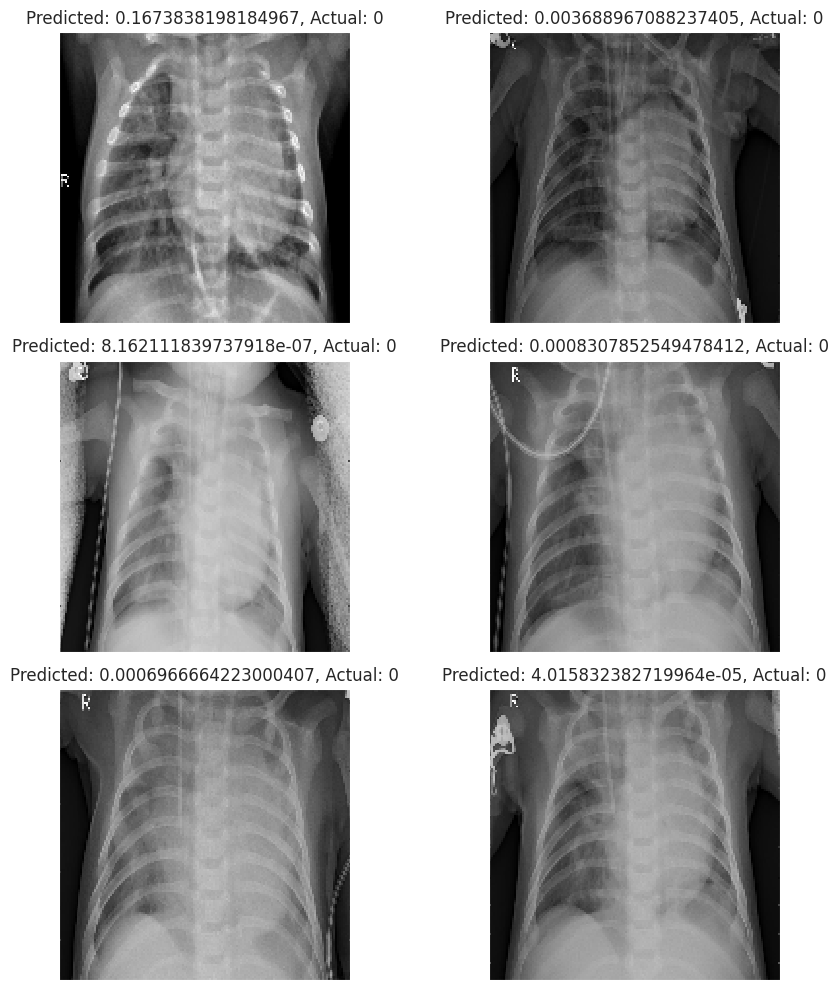

In [111]:
import matplotlib.pyplot as plt

# Set the figure size for better visibility
plt.figure(figsize=(10, 10))

# Iterate over the first 6 correct predictions
for i, c in enumerate(correct[:6]):
    plt.subplot(3, 2, i + 1)  # Create a subplot
    plt.imshow(x_test[c].reshape(150, 150), cmap="gray", interpolation='none')  # Show the image

    # Hide axis ticks
    plt.xticks([])
    plt.yticks([])

    # Add title with enhanced formatting
    plt.title(f"Predicted: {predictions[c]}, Actual: {y_test[c]}", fontsize=12)

# Improve layout and show the plot
plt.tight_layout()
plt.show()


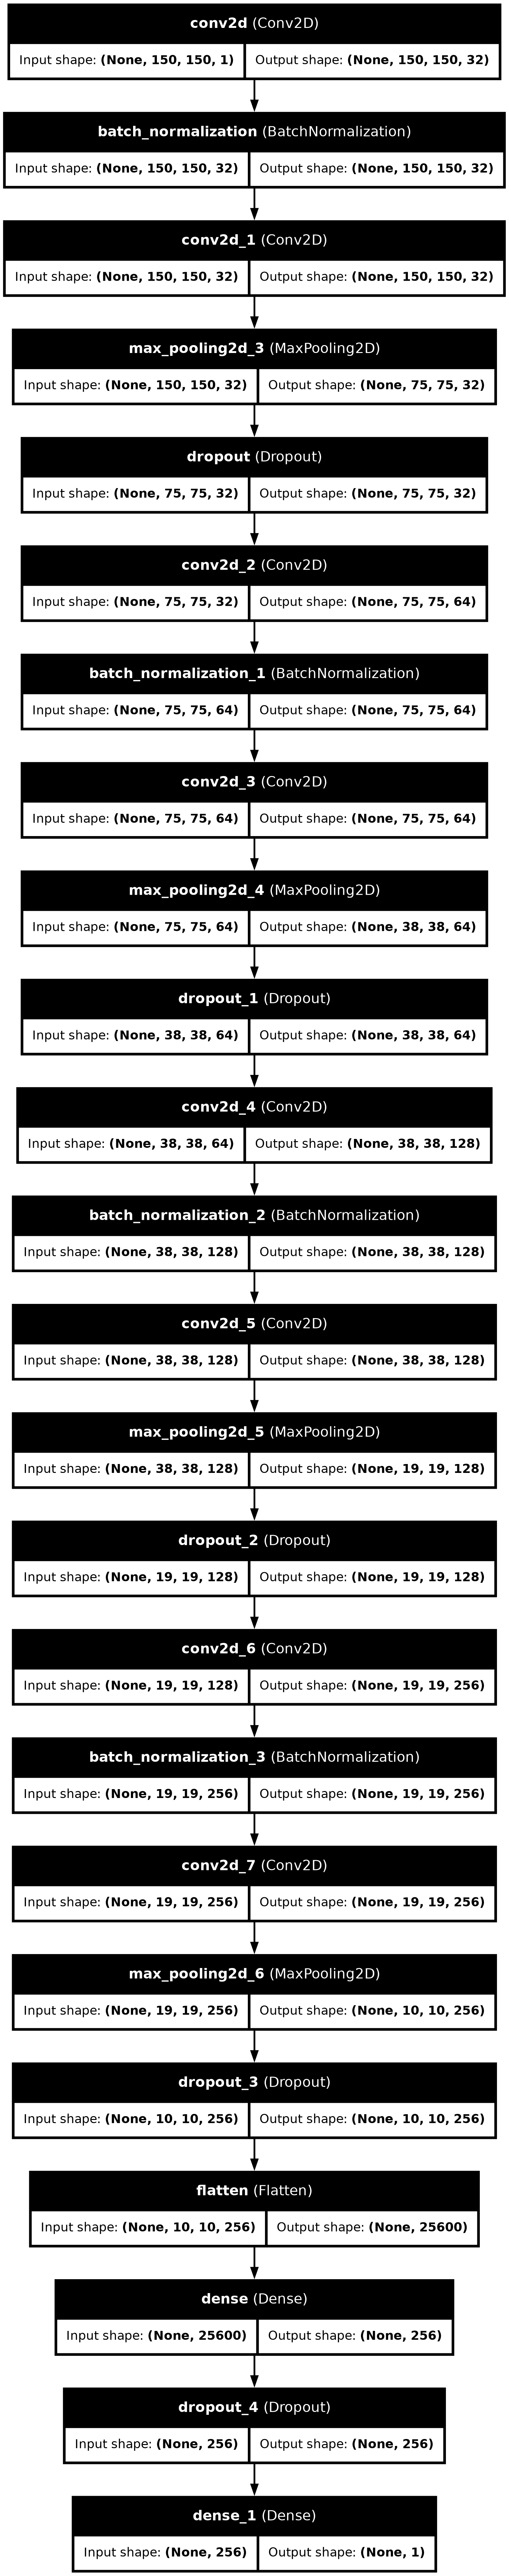

In [ ]:
from tensorflow.keras.utils import plot_model
from PIL import Image as PILImage  # Make sure to import the correct Image class
from IPython.display import display

# Visualize the model architecture
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Display the saved model architecture image
display(PILImage.open('model.png'))  # Use PILImage to open the image


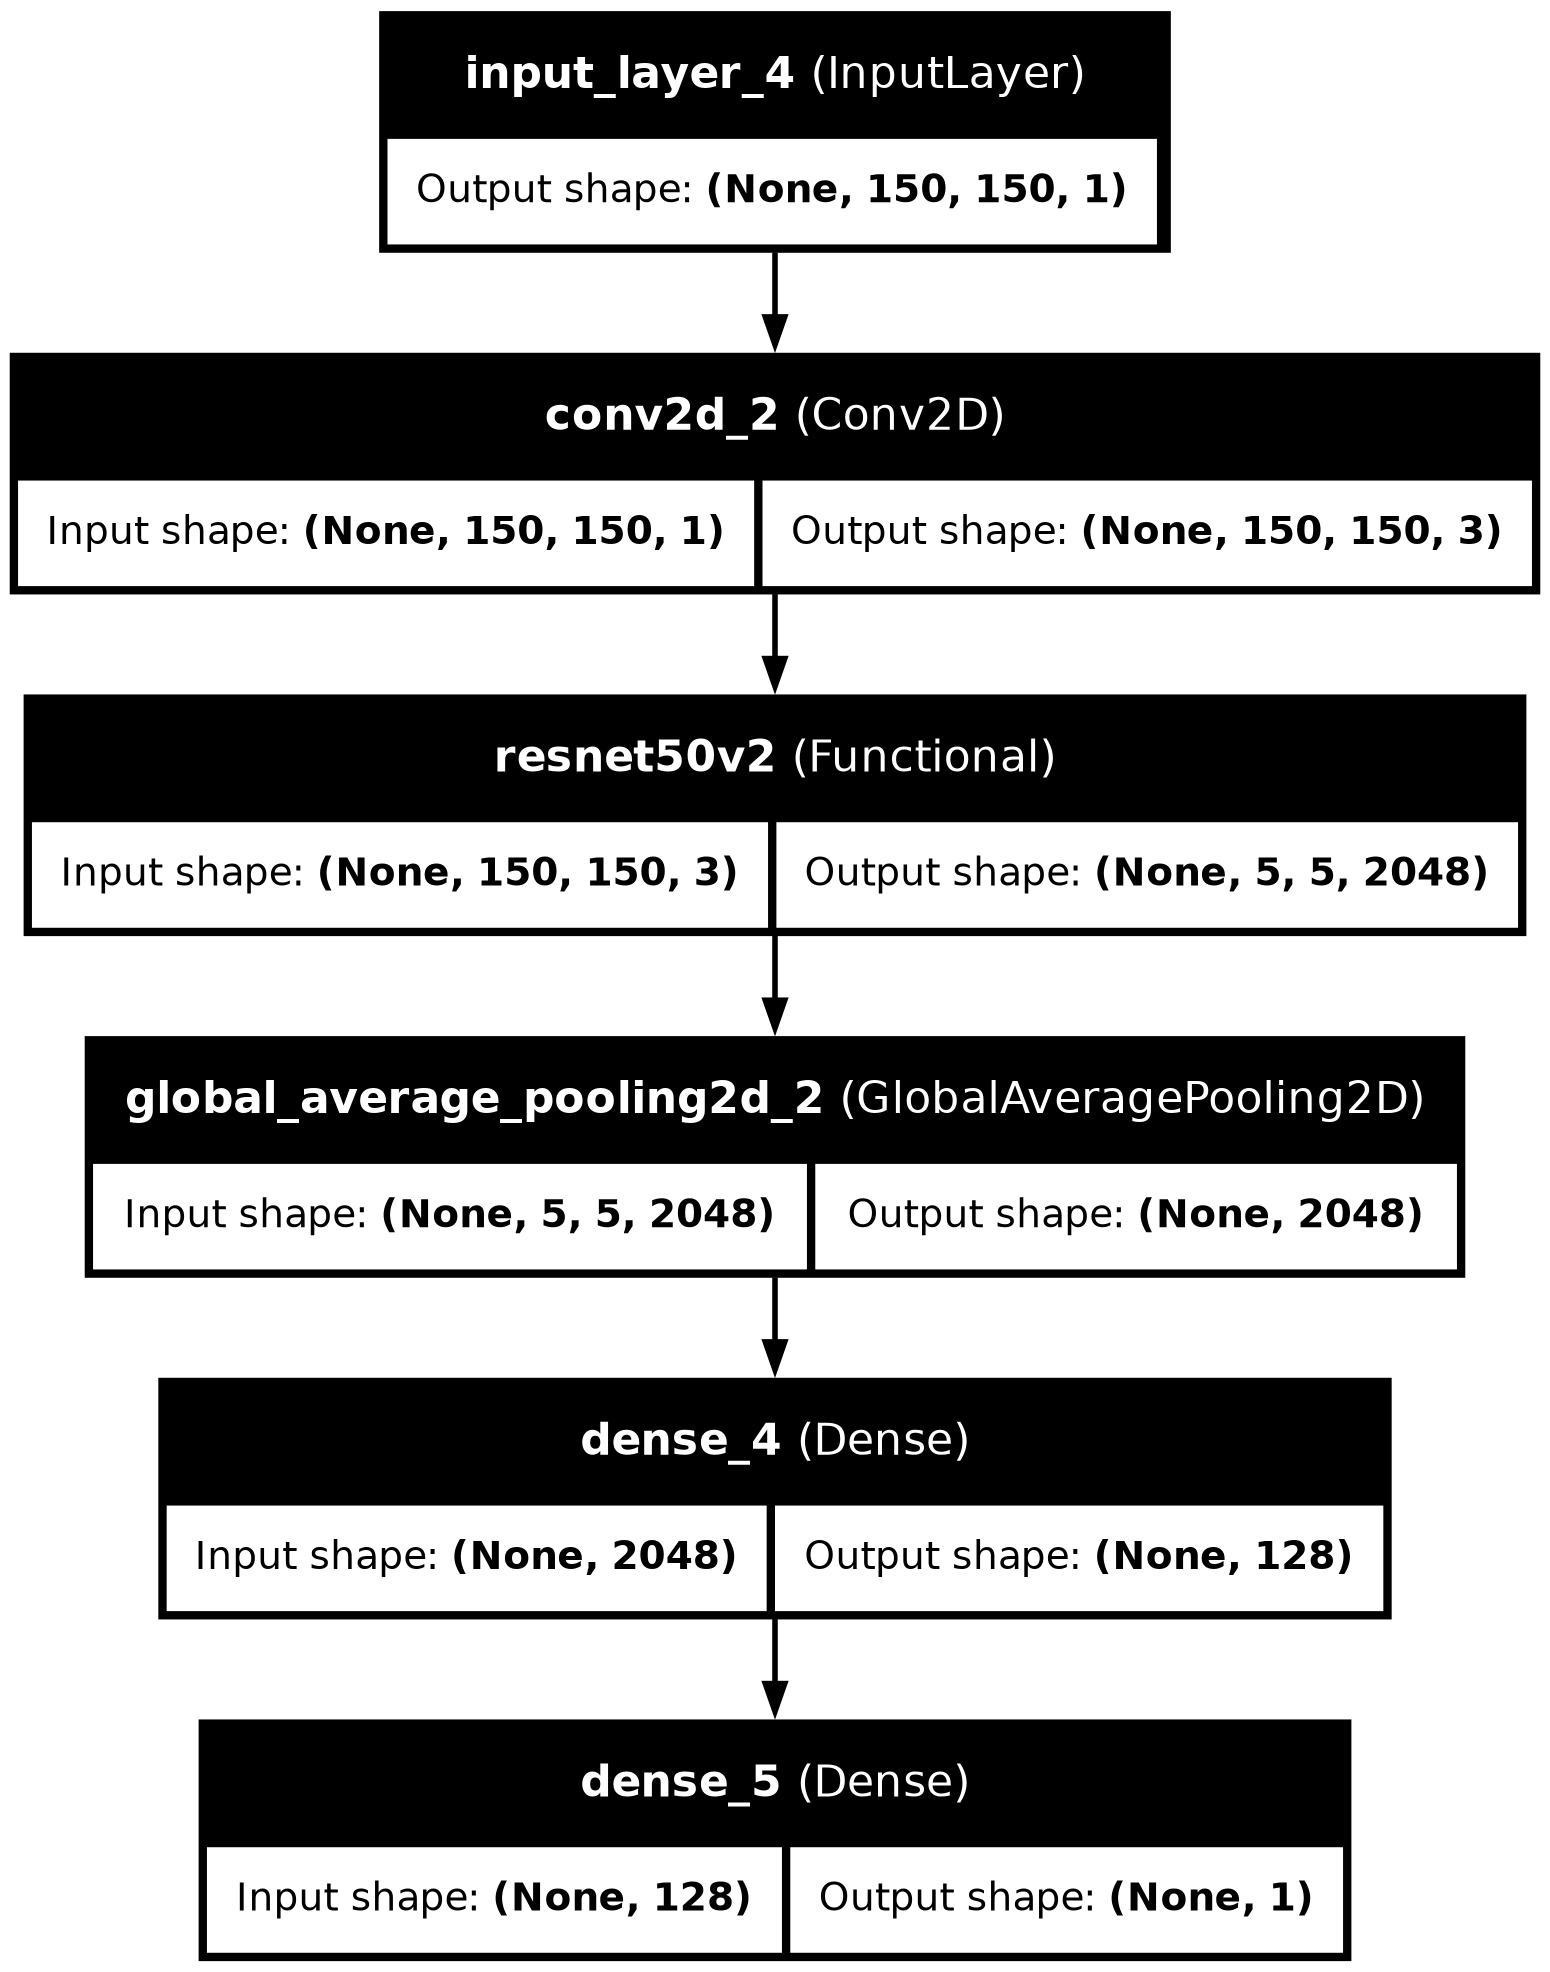

In [115]:
from tensorflow.keras.utils import plot_model
from PIL import Image as PILImage  # Make sure to import the correct Image class
from IPython.display import display

# Visualize the model architecture
plot_model(res_model, to_file='res_model.png', show_shapes=True, show_layer_names=True)

# Display the saved model architecture image
display(PILImage.open('res_model.png'))  # Use PILImage to open the image


In [114]:
import tensorflow as tf

# Load the ResNet50V2 model without the top layer
resnet_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)  # ResNet expects 3-channel input
)

# Print the summary of the ResNet50V2 model
resnet_model.summary()


Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 38, 38,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 38, 38,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 40, 40,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 38, 38,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)